In [2]:
import os
import cv2
import mediapipe as mp
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

torch.cuda.is_available()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=True,
    max_num_hands=1,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

train_dir = ".\\transformed_data"
train_path, test_path = ".\\train.csv", ".\\test.csv"

def dataset2images(root_dir, output_path):
    datasets = []
    for img_name in tqdm(os.listdir(root_dir)):
        img_path = os.path.join(root_dir, img_name)
        image = cv2.imread(img_path)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        landmarks = []
        results = hands.process(image_rgb)
        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                for lm in hand_landmarks.landmark:
                    landmarks.append(lm.x)
                    landmarks.append(lm.y)
                    landmarks.append(lm.z)
                datasets.append(landmarks + [img_name[0]])
            
    pd.DataFrame(datasets).to_csv(output_path, header=False, index=False)

In [4]:
# dataset2images(train_dir, train_path)
# dataset2images(train_dir, test_path)

In [5]:
class KeypointsDataset(Dataset):
    def __init__(self, data_path, transform=None):
        self.data_path = data_path
        self.transform = transform
        self.samples = pd.read_csv(data_path).to_numpy()

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        keypoints = sample[:-1].astype(np.float32)
        label = sample[-1].astype(np.int64)

        keypoints = self.transform(keypoints) if self.transform else torch.tensor(keypoints, dtype=torch.float32)
        return keypoints, label

def keypoints_transform(keypoints):
    # 1. 将一维数组 (63,) 重塑为 (21, 3) 的矩阵
    kp_matrix = torch.tensor(keypoints, dtype=torch.float32).reshape(21, 3)
    # 2. 获取手腕坐标 (第0行)
    wrist = kp_matrix[0].clone()  # Shape: (3,)
    # 3. 所有点减去手腕坐标 (广播机制，自动应用到每一行)
    kp_matrix -= wrist
    # 4. 归一化 (保持原有逻辑，缩放到 -1 到 1)
    # 注意：这里建议用所有相对坐标的最大值来缩放，保持长宽比
    max_val = torch.max(torch.abs(kp_matrix))
    if max_val > 0:
        kp_matrix /= max_val
    # 5. 展平回 (63,)
    return kp_matrix.flatten()

train_dataset = KeypointsDataset(train_path, transform=keypoints_transform)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataset = KeypointsDataset(test_path, transform=keypoints_transform)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [6]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(63, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)
        # self.bn = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)
        return x

In [7]:
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

In [8]:
def train(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for keypoints, labels in dataloader:
        keypoints, labels = keypoints.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(keypoints)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * keypoints.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for keypoints, labels in dataloader:
            keypoints, labels = keypoints.to(device), labels.to(device)

            outputs = model(keypoints)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * keypoints.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

Epoch 1/1000, Train Loss: 2.2884, Train Acc: 0.1046, Test Loss: 2.2769, Test Acc: 0.1340
Epoch 100/1000, Train Loss: 0.9620, Train Acc: 0.6275, Test Loss: 0.7833, Test Acc: 0.7255
Epoch 200/1000, Train Loss: 0.5658, Train Acc: 0.8235, Test Loss: 0.4056, Test Acc: 0.8791
Epoch 300/1000, Train Loss: 0.4509, Train Acc: 0.8333, Test Loss: 0.2138, Test Acc: 0.9510
Epoch 400/1000, Train Loss: 0.3166, Train Acc: 0.9020, Test Loss: 0.1206, Test Acc: 0.9739
Epoch 500/1000, Train Loss: 0.2431, Train Acc: 0.9281, Test Loss: 0.0779, Test Acc: 0.9837
Epoch 600/1000, Train Loss: 0.2195, Train Acc: 0.9183, Test Loss: 0.0546, Test Acc: 0.9902
Epoch 700/1000, Train Loss: 0.2100, Train Acc: 0.9346, Test Loss: 0.0363, Test Acc: 1.0000
Epoch 800/1000, Train Loss: 0.1139, Train Acc: 0.9706, Test Loss: 0.0232, Test Acc: 1.0000
Epoch 900/1000, Train Loss: 0.0963, Train Acc: 0.9706, Test Loss: 0.0176, Test Acc: 1.0000
Epoch 1000/1000, Train Loss: 0.0923, Train Acc: 0.9771, Test Loss: 0.0126, Test Acc: 1.0000


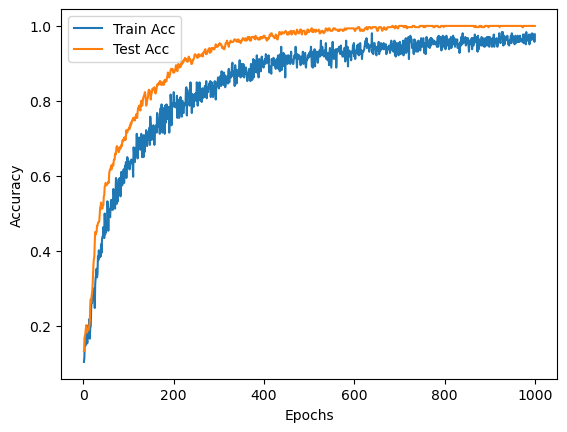

In [13]:
EPOCHS = 1000
train_acces = []
test_acces = []

for epoch in range(EPOCHS):
    train_loss, train_acc = train(model, train_dataloader, criterion, optimizer, device)
    test_loss, test_acc = evaluate(model, test_dataloader, criterion, device)
    if (epoch + 1) % 100 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{EPOCHS}, "
            f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
            f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    train_acces.append(train_acc)
    test_acces.append(test_acc)

plt.plot(range(1, EPOCHS+1), train_acces, label='Train Acc')
plt.plot(range(1, EPOCHS+1), test_acces, label='Test Acc')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [9]:
# torch.save(model.state_dict(), "mlp_model_weights.pth")

model = MLP().to(device)
model.load_state_dict(torch.load("mlp_model_weights.pth"))
model.eval()

MLP(
  (fc1): Linear(in_features=63, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (relu): ReLU()
)

In [10]:
cap = cv2.VideoCapture(0)

mp_hands = mp.solutions.hands
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)


while True:
    ret, frame = cap.read()
    if not ret:
        break

    # frame = cv2.flip(frame, 1)
    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    machine_left = 0
    machine_right = 0

    if results.multi_hand_landmarks:
        for hand_landmarks, hand_info in zip(results.multi_hand_landmarks, results.multi_handedness):
            # 获取手的左右
            hand_label = hand_info.classification[0].label  # 'Left' 或 'Right'

            # ①提取关键点
            keypoints = []
            for lm in hand_landmarks.landmark:
                keypoints.extend([lm.x, lm.y, lm.z])
            keypoints = keypoints_transform(keypoints).unsqueeze(0).to(device)

            # ②预测手势数字
            res = model(keypoints)
            predicted_class = torch.argmax(res, dim=1).item()

            # ③累加到对应手
            if hand_label == "Left":
                machine_left += predicted_class
            else:
                machine_right += predicted_class

            # ④绘制框和预测结果
            h, w, c = frame.shape
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)
            x_list = [int(lm.x * w) for lm in hand_landmarks.landmark]
            y_list = [int(lm.y * h) for lm in hand_landmarks.landmark]
            x_min, x_max = min(x_list), max(x_list)
            y_min, y_max = min(y_list), max(y_list)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,255,0), 2)
            cv2.putText(frame, str(predicted_class), (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)



    
    cv2.imshow("Hand Tracking", frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

In [ ]:
import cv2
import mediapipe as mp

# -------------------
# 初始化
# -------------------
mp_hands = mp.solutions.hands
mp_draw = mp.solutions.drawing_utils

hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.5,
    min_tracking_confidence=0.5
)

cap = cv2.VideoCapture(1)

# 设置碰检测阈值（可根据摄像头调节）
Z_THRESHOLD = -0.03

while True:
    ret, frame = cap.read()
    if not ret:
        break

    frame = cv2.flip(frame, 1)  # 镜像
    h, w, c = frame.shape

    img_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    results = hands.process(img_rgb)

    if results.multi_hand_landmarks:
        for hand_landmarks, hand_info in zip(results.multi_hand_landmarks, results.multi_handedness):
            hand_label = hand_info.classification[0].label  # 'Left' 或 'Right'

            # -------------------
            # 绘制手关键点
            mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

            # -------------------
            # 计算手框
            x_list = [int(lm.x * w) for lm in hand_landmarks.landmark]
            y_list = [int(lm.y * h) for lm in hand_landmarks.landmark]
            x_min, x_max = min(x_list), max(x_list)
            y_min, y_max = min(y_list), max(y_list)
            cv2.rectangle(frame, (x_min, y_min), (x_max, y_max), (0,255,0), 2)

            # -------------------
            # 获取手掌中心 z 值
            z_value = hand_landmarks.landmark[9].z
            is_touching = z_value < Z_THRESHOLD

            # -------------------w
            # 显示状态 + z 值
            status_text = f'{hand_label} z={z_value:.3f} {"Touch!" if is_touching else "Idle"}'
            cv2.putText(frame, status_text, (x_min, y_min - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,0,255) if is_touching else (255,0,0), 2)

    cv2.imshow("Hand Touch Detection with Z", frame)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()
